# HSE 2022: Mathematical Methods for Data Analysis

## Homework 2

In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import datasets
from sklearn.datasets import load_boston
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLSResults
from math import sqrt
import random
import sys

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

sns.set(style="darkgrid")

### Data

For this homework we use Dataset from seaborn on diamonds prices.

In [241]:
data = sns.load_dataset('diamonds')

In [242]:
print(data)

       carat        cut color clarity  depth  table  price     x     y     z
0       0.23      Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1       0.21    Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2       0.23       Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3       0.29    Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4       0.31       Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
...      ...        ...   ...     ...    ...    ...    ...   ...   ...   ...
53935   0.72      Ideal     D     SI1   60.8   57.0   2757  5.75  5.76  3.50
53936   0.72       Good     D     SI1   63.1   55.0   2757  5.69  5.75  3.61
53937   0.70  Very Good     D     SI1   62.8   60.0   2757  5.66  5.68  3.56
53938   0.86    Premium     H     SI2   61.0   58.0   2757  6.15  6.12  3.74
53939   0.75      Ideal     D     SI2   62.2   55.0   2757  5.83  5.87  3.64

[53940 rows x 10 columns]


## Linear regression

#### 0. [0.25 points] Encode categorical variables.

В наборе данных три категориальные переменные - cut, color, clarity. Используем фиктивное кодирование с drop_first = True (для уменьшения столбцов и корреляции). Так как кодирование происходит до построения моделей ML, можем использовать get_dummies().

In [243]:
# Применяем фиктивное кодирование Pandas.
data = pd.get_dummies(data, prefix={'color':'color', 'cut':'cut', 'clarity':'clarity'}, drop_first=True)

#### 1. [0.25 points] Split the data into train and test sets with ratio 80:20 with random_state=17.

In [244]:
# Целевыми данными являются значения столбца с ценой бриллиантов.
y = data['price']
X = data.drop(columns=['price'], axis=1)
# Эта вещь понадобится в задании 4.
X_start = X.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

#### 2. [1 point] Train models on train data using StatsModels library and apply it to the test set; use $RMSE$ and $R^2$ as the quality measure.

* [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html);
* [`Ridge`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) with $\alpha = 0.01$;
* [`Lasso`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) with $\alpha = 0.01$
* [`ElasticNet`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) with $\alpha = 0.01$, $l_{1}$_$ratio = 0.6$

Don't forget to scale the data before training the models with StandardScaler!

**МЕГАВАЖНОЕ уточнение** от студента: в задании просят использовать модели StatsModels. В случае простой линейной регрессии не возникает проблем, но при регуляризации появляется сложность - метод $summary()$, который предоставляет необходимую информацию о статистическом анализе, не работает. Эта проблема решается заданием параметра $refit = True$, однако тогда смысл регуляризации фактически теряется, и на выходе получается четыре модели с идентичными характеристиками. Вопрос был обсужден с семинаристами, указание - использовать параметр $refit = True$ и принять факт неточности...   
Мне захотелось продемонстрировать, что в нормальных условиях, когда все работает, модели все-таки имеют разные значения характеристик, поэтому:   
1) Во 2 номере я не использую $refit = True$, чтобы задание имело смысл и можно было сравнить $R^2$ и $RMSE$;   
2) В 3 задании я использую $refit = True$, чтобы работал вывод результирующих таблиц (бессмысленно, но так требуется в задании).

In [245]:
# LinearRegression

# Обработка с помощью StandardScaler.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Добавление константы.
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Использование StatsModels.
model = sm.OLS(y_train, X_train_scaled);  # Используем как шаблон для всех моделей.
linear_trained = model.fit()

# Прогнозные значения.
y_pred = linear_trained.predict(X_test_scaled)
y_train_pred = linear_trained.predict(X_train_scaled)

# Вывод RMSE и R^2.
print("Test RMSE = %.4f" % sqrt(mean_squared_error(y_test, y_pred)))
print("Train RMSE = %.4f" % sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test R2 = %.4f" % r2_score(y_test, y_pred))
print("Train R2 = %.4f" % r2_score(y_train, y_train_pred))

Test RMSE = 1149.9905
Train RMSE = 1124.9250
Test R2 = 0.9183
Train R2 = 0.9201


In [246]:
# Lasso

# Использование StatsModels.
lasso_trained = model.fit_regularized(alpha=0.01, L1_wt=1.0)

# Прогнозные значения.
y_pred = lasso_trained.predict(X_test_scaled)
y_train_pred = lasso_trained.predict(X_train_scaled)

# Вывод RMSE и R^2.
print("Test RMSE = %.4f" % sqrt(mean_squared_error(y_test, y_pred)))
print("Train RMSE = %.4f" % sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test R2 = %.4f" % r2_score(y_test, y_pred))
print("Train R2 = %.4f" % r2_score(y_train, y_train_pred))

Test RMSE = 1148.7777
Train RMSE = 1125.2157
Test R2 = 0.9185
Train R2 = 0.9201


In [247]:
# Ridge

# Использование StatsModels.
ridge_trained = model.fit_regularized(alpha=0.01, L1_wt=0.0)

# Прогнозные значения.
y_pred = ridge_trained.predict(X_test_scaled)
y_train_pred = ridge_trained.predict(X_train_scaled)

# Вывод RMSE и R^2.
print("Test RMSE = %.4f" % sqrt(mean_squared_error(y_test, y_pred)))
print("Train RMSE = %.4f" % sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test R2 = %.4f" % r2_score(y_test, y_pred))
print("Train R2 = %.4f" % r2_score(y_train, y_train_pred))

Test RMSE = 1163.5760
Train RMSE = 1147.6263
Test R2 = 0.9164
Train R2 = 0.9169


In [248]:
# ElasticNet

# Использование StatsModels.
en_trained = model.fit_regularized(alpha=0.01, L1_wt=0.6)

# Прогнозные значения.
y_pred = en_trained.predict(X_test_scaled)
y_train_pred = en_trained.predict(X_train_scaled)

# Вывод RMSE и R^2.
print("Test RMSE = %.4f" % sqrt(mean_squared_error(y_test, y_pred)))
print("Train RMSE = %.4f" % sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test R2 = %.4f" % r2_score(y_test, y_pred))
print("Train R2 = %.4f" % r2_score(y_train, y_train_pred))

Test RMSE = 1150.1025
Train RMSE = 1130.8930
Test R2 = 0.9183
Train R2 = 0.9193


Таким образом, для тестового набора имеем следующие выводы:   
1) Наименьшее значение $RMSE$ имеет модель $Lasso$, наибольшее - модель $Ridge$;   
2) Наибольше значение $R^2$ имеет модель $Lasso$, наименьшее - модель $Ridge$;   
3) По всем параметрам лучшие показатели имеет модель $Lasso$, худшие - модель $Ridge$.

#### 3. [1 point] Explore the values of the parameters of the resulting models and compare the number of zero weights in them. Comment on the significance of the coefficients, overal model significance and other related factors from the results table

In [249]:
# Вывод коэффициентов.
print("Linear regression:")
print(linear_trained.params)
print()

print("Lasso:")
print(lasso_trained.params)
print()

print("Ridge:")
print(ridge_trained.params)
print()

print("ElasticNet:")
print(en_trained.params)
print()

Linear regression:
const    3928.681289
x1       5386.710073
x2        -97.928473
x3        -61.694505
x4      -1186.228017
x5          2.815617
x6        -31.770464
x7        -32.963139
x8        -40.804137
x9        -72.447500
x10      -141.035551
x11       -85.479445
x12      -109.491054
x13      -197.533045
x14      -361.318575
x15      -447.734241
x16      -527.380300
x17       -86.402868
x18      -120.164278
x19      -281.452704
x20      -455.320491
x21      -722.777835
x22      -998.025513
x23      -615.482296
dtype: float64

Lasso:
const    3928.671289
x1       5266.791581
x2        -92.666578
x3        -62.364674
x4      -1087.581194
x5         12.970426
x6        -24.668775
x7        -32.101091
x8        -40.202550
x9        -72.436309
x10      -141.262835
x11       -84.814405
x12      -109.159587
x13      -196.318006
x14      -358.902505
x15      -444.385685
x16      -524.186002
x17       -78.116051
x18      -111.436270
x19      -272.445593
x20      -444.647257
x21      -713

Стоит отметить, что ни в одной модели нет нулевых коэффициентов, что может быть связано с используемой библиотекой и/ или заданием параметра $\alpha$.   
Если задать модель $Lasso$ через $Sklearn$ и указать $\alpha = 1.0$, то мы увидим нулевой коэффициент.

In [250]:
# Чисто ради интереса.
sk_model = Lasso()
sk_lasso_trained = sk_model.fit(X_train_scaled, y_train)
print(sk_lasso_trained.coef_)

[    0.          5339.7488448    -95.42090868   -62.12190874
 -1139.37535557    -0.           -32.27219888   -31.48401164
   -39.05386462   -71.21050796  -140.24767682   -78.21894725
  -101.74465338  -188.4477032   -353.0486872   -440.15140659
  -521.25881488   -68.5786542    -99.72170286  -257.20375048
  -426.50874167  -693.73914792  -971.46382923  -606.34333425]


In [251]:
# Узнаем, какой именно параметр обнулился.
print(X_train.columns[4])

y


Мы видим, что нулевым стал параметр $x_5$ ($y$ - ширина), который в обычной линейной регрессии как раз имеет самый низкий коэффициент, поэтому его "выброс" наиболее ожидаем.

Теперь приступим к выводам результирующих табличек для моделей. Как раз сейчас необходимо указать $refit = True$, иначе метод $summary()$ просто не сработает. При этом повторюсь, что фактически регуляризации не произойдет, поэтому все данные будут идентичны.

In [252]:
# Вывод результирующих таблиц для всех моделей.
print(linear_trained.summary())

lasso_trained = model.fit_regularized(alpha=0.01, L1_wt=1.0, refit=True)
print(lasso_trained.summary())

# ВАЖНО: с реализацией Ridge() в StatsModels все плохо, поэтому при L1 = 0 summary() также не работает.
# Укажем значение, близкое к нулю, чтобы вывести результирующую таблицу.
ridge_trained = model.fit_regularized(alpha=0.01, L1_wt=1e-20, refit=True)
print(ridge_trained.summary())

en_trained = model.fit_regularized(alpha=0.01, L1_wt=0.6, refit=True)
print(en_trained.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                 2.160e+04
Date:                Sun, 16 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:43:22   Log-Likelihood:            -3.6439e+05
No. Observations:               43152   AIC:                         7.288e+05
Df Residuals:                   43128   BIC:                         7.290e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3928.6813      5.417    725.275      0.0

Все сработало и мы получили 4 идентичные таблички, ч.т.д..   
По этой причине вывод по статистическим параметрам сделаем только для линейной регрессии, так как при регуляризации мы не можем получить верных результатов.   
Рассмотрим уровень значимости $0.05$:    
1) Согласно значению $p-value$ незначимыми являются параметры $x_5$ - ширина ($p-value = 0.909$) и $x_6$ - глубина ($p-value = 0.2$). Остальные параметры значимы;   
2) Оценим уровень значимости регрессии в целом: $F-statistic = 20700$, $F-critical = finv(0.95, 23, 53940 - 23 - 1) = 1.5295$. Как видим, $F-statistic>F-critical$, а значит, согласно тесту Фишера, регрессия значима в целом;   
3) $R^2 = R^2 (adj.) = 0.92$, показатель достаточно близок к $1$, что хорошо;   
4) $DW = 2$, что говорит об отсутствии автокорреляции;   
5) Сравнительные параметры $AIC/ BIC$ и так далее рассматривать не будем, так как все модели идентичны и сравнивать нечего ☕

#### 4. [1 point] Implement one of the elimination algorithms that were described in the Seminar_4 (Elimination by P-value, Forward elimination, Backward elimination), make conclusions.

Реализуем метод устранения по значениям $p-value$ и параллельно будем смотреть на то, как меняется при этом качественная характеристика модели (в реализации ниже - $RMSE$), чтобы понять, имеет ли в принципе смысл выброс параметров из модели.


In [253]:
'''
Метод, осуществляющий исключение по p-value.
При этом учитываем показатель RMSE в качестве эффективности модели.
'''
def elimination_pvalue(x_start):
  columns = list(x_start)

  # Будем хранить значения R-квадрата после каждого преобразования.
  # Потом выберем наилучший.
  dict_rmse = {}
  while len(columns):
    X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(x_start[columns], y, test_size=0.2, random_state=17)
    # Заново строим модель.
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train_e[columns])
    X_test_sc = scaler.transform(X_test_e[columns])
    X_train_sc = sm.add_constant(X_train_sc)
    X_test_sc = sm.add_constant(X_test_sc)

    model = sm.OLS(y_train_e, X_train_sc).fit()
    y_pred_e = model.predict(X_test_sc)
    
    # Вычисление R-квадрата и занесение информации в словарь.
    rmse = mean_squared_error(y_test_e, y_pred_e)
    dict_rmse[rmse] = columns.copy()
    # Удаление p-value с максимальной величиной (начинаем с 1, так как есть константа)
    del columns[model.pvalues.iloc[1:].argmax()]
  # Возвращаем столбцы со значимыми переменными
  return dict_rmse[min(dict_rmse)]

In [254]:
significant = elimination_pvalue(X_start)
print(significant)

['carat', 'depth', 'table', 'x', 'y', 'z', 'cut_Premium', 'cut_Very Good', 'cut_Good', 'cut_Fair', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_VVS1', 'clarity_VVS2', 'clarity_VS1', 'clarity_VS2', 'clarity_SI1', 'clarity_SI2', 'clarity_I1']


Мы не зря проверили качественную характеристику. Как оказалось, выброс параметров из модели привел к ухудшению (студент проверил и для $R^2$, код аналогичен, ухудшение аналогично).   
Тем не менее, для большей наглядности (и выброса меньшего количества параметров) предлагаю реализовать данный метод устранения поэтапно.

In [255]:
print(linear_trained.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                 2.160e+04
Date:                Sun, 16 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:43:32   Log-Likelihood:            -3.6439e+05
No. Observations:               43152   AIC:                         7.288e+05
Df Residuals:                   43128   BIC:                         7.290e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3928.6813      5.417    725.275      0.0

Начальная ситуация, параметр $x_5$ имеет наибольшее значение $p-value$, так что нужно выбросить данный параметр и перестроить модель. Будем также оценивать $RMSE$ (вначале $= 1149.9905$).

In [256]:
# Выбрасываем столбец и заново строим модель (иначе результаты будут неверны).
X_start = X_start.drop(['y'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_start, y, test_size=0.2, random_state=17)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

model = sm.OLS(y_train, X_train_scaled);
linear_trained = model.fit()
y_pred = linear_trained.predict(X_test_scaled)

print(linear_trained.summary())
print("Test RMSE = %.4f" % sqrt(mean_squared_error(y_test, y_pred)))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                 2.259e+04
Date:                Sun, 16 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:43:32   Log-Likelihood:            -3.6439e+05
No. Observations:               43152   AIC:                         7.288e+05
Df Residuals:                   43129   BIC:                         7.290e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3928.6813      5.417    725.284      0.0

Теперь параметр $x_5$ уже в новой модели (то есть это другой параметр) имеет наибольшее значение $p-value$, так что нужно выбросить данный параметр и перестроить модель.

In [257]:
# Выбрасываем столбец и заново строим модель (иначе результаты будут неверны).
X_start = X_start.drop(['z'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_start, y, test_size=0.2, random_state=17)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

model = sm.OLS(y_train, X_train_scaled);
linear_trained = model.fit()
y_pred = linear_trained.predict(X_test_scaled)

print(linear_trained.summary())
print("Test RMSE = %.4f" % sqrt(mean_squared_error(y_test, y_pred)))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                 2.366e+04
Date:                Sun, 16 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:43:32   Log-Likelihood:            -3.6439e+05
No. Observations:               43152   AIC:                         7.288e+05
Df Residuals:                   43130   BIC:                         7.290e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3928.6813      5.417    725.278      0.0

После удаления двух параметров (которые и были указаны, как незначимые, в задании №3) больше нет высоких значений $p-value$, то есть удаление нужно прекратить. Однако, как и было указано выше, качественные характеристики при таком подходе немного ухудшились.

In [258]:
# После манипуляций в 4 номере возвращаем исходные данные.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

#### 5. [1 point] Find the best (in terms of RMSE) $\alpha$ for Lasso regression using cross-validation with 4 folds. You must select values from range $[10^{-4}, 10^{3}]$.

In [259]:
alphas = np.logspace(-4, 3)
searcher = GridSearchCV(Lasso(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=4)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

Best alpha = 0.7197


## Gradient descent

#### 6. [3.5 points] Implement a Ridge regression model for the MSE loss function, trained by gradient descent.

All calculations must be vectorized, and python loops can only be used for gradient descent iterations. As a stop criterion, you must use (simultaneously):

* checking for the Absolute-value norm of the weight difference on two adjacent iterations (for example, less than some small number of the order of $10^{-6}$, set by the `tolerance` parameter);
* reaching the maximum number of iterations (for example, 10000, set by the `max_iter` parameter).

You need to implement:

* Full gradient descent:

$$
w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

* Stochastic Gradient Descent:

$$
w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} q_{i_{k}}(w_{k}).
$$

$\nabla_{w} q_{i_{k}}(w_{k}) \, $ is the estimate of the gradient over the batch of objects selected randomly.

* Momentum method:

$$
h_0 = 0, \\
h_{k + 1} = \alpha h_{k} + \eta_k \nabla_{w} Q(w_{k}), \\
w_{k + 1} = w_{k} - h_{k + 1}.
$$

* Adagrad method:

$$
G_0 = 0, \\
G_{k + 1} = G_{k} + (\nabla_{w} Q(w_{k+1}))^2, \\
w_{k + 1} = w_{k} - \eta * \frac{\nabla_{w} Q(w_{k+1})}{\sqrt{G_{k+1} + \epsilon}}.
$$



To make sure that the optimization process really converges, we will use the `loss_history` class attribute. After calling the `fit` method, it should contain the values of the loss function for all iterations, starting from the first one (before the first step on the anti-gradient).

You need to initialize the weights with a random vector from normal distribution. The following is a template class that needs to contain the code implementing all variations of the models.

Честно признаюсь: метод $Adagrad$ не получилось реализовать верно, что-то ломается...

In [260]:
from sklearn.metrics._plot.precision_recall_curve import precision_recall_curve
from sklearn.base import BaseEstimator

class LinReg(BaseEstimator):
    def __init__(self, delta=1.0, gd_type='Momentum', 
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2, alpha=1e-3, reg_cf=0.0, epsilon = 1e-9):
        """
        gd_type: str
            'GradientDescent', 'StochasticDescent', 'Momentum', 'Adagrad'
        delta: float
            proportion of object in a batch (for stochastic GD)
        tolerance: float
            for stopping gradient descent
        max_iter: int
            maximum number of steps in gradient descent
        w0: np.array of shape (d)
            init weights
        eta: float
            learning rate
        alpha: float
            momentum coefficient
        reg_cf: float
            regularization coefficient
        epsilon: float
            numerical stability
        """
        
        self.delta = delta
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration
        self.reg_cf = reg_cf  # Коэффициент регуляризации, в документации вроде был указан.
        self.momentum = 0  # Введем дополнительную переменную (h) для метода Momentum.
        self.adagrad = 0  # Введем дополнительную переменную (G) для метода Adagrad.
        self.epsilon = epsilon
    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        self.loss_history = []
        X = np.array(X)
        y = np.array(y)
        
        # Начальное заполнение весов.
        if self.w0 is None:
          self.w0 = np.zeros(X.shape[1])
        self.w = self.w0

        self.loss_history.append(self.calc_loss(X, y))
        # Учитываем условия остановки в цикле - max_iter и tolerance.
        for i in range(self.max_iter):
          current_gradient = self.calc_gradient(X, y)
          if np.linalg.norm(current_gradient) < self.tolerance:
            break
          self.w = self.w - current_gradient
          self.loss_history.append(self.calc_loss(X, y))

        return self
    

    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        # Матричное умножение на веса.
        return X @ self.w.T
    
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        # Параметр delta только для SGD, для остальных по условию delta = 1.0
        batch_size = int(X.shape[0] * self.delta)
        rand_data = np.random.randint(0, X.shape[0], batch_size)
        X = X[rand_data, :]
        y = y[rand_data]

        # Основная формула градиента для Ridge модели.
        gradient = -2 * np.dot(X.T, y - np.dot(X, self.w)) / batch_size + 2 * self.reg_cf * self.w
        gradient *= self.eta

        if self.gd_type == 'Momentum':
          gradient += self.momentum * self.alpha  # Прибавляем коэффициент из формулы для метода Momentum.
          self.momentum = gradient
        
        if self.gd_type == 'Adagrad':
          gradient /= self.eta
          self.adagrad += gradient.dot(gradient)
          return self.eta * (gradient) / np.sqrt(self.adagrad + self.epsilon)

        return gradient


    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """ 
        prediction = self.predict(X)
        # Используем формулу MSE с учетом смещения.
        return np.sum((y - prediction) ** 2) / y.shape[0] + self.reg_cf * np.sum(self.w ** 2)

#### 7. [1 points] Train and validate "hand-written" models on the same data, and compare the quality with the Sklearn or StatsModels methods. Investigate the effect of the `max_iter` and `alpha` parameters on the optimization process. Is it consistent with your expectations?

Для разнообразия в этом задании будем использовать модель Sklearn, так как для модели StatsModels уже найдены все параметры в задании 2. 

In [261]:
np.random.seed(0)
model = Ridge()
sk_ridge_trained = model.fit(X_train_scaled, y_train)

# Прогнозные значения.
y_pred = sk_ridge_trained.predict(X_test_scaled)
print("Ridge:")
print("Test RMSE = %.4f" % sqrt(mean_squared_error(y_test, y_pred)))
print("Test R2 = %.4f" % r2_score(y_test, y_pred))

lr = LinReg()
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
print("LinReg:")
print("Test RMSE = %.4f" % sqrt(mean_squared_error(y_test, lr_pred)))
print("Test R2 = %.4f" % r2_score(y_test, lr_pred))

Ridge:
Test RMSE = 1149.9456
Test R2 = 0.9183
LinReg:
Test RMSE = 1231.7944
Test R2 = 0.9063


Мы видим, что собственная модель показала результаты хуже, чем модель Sklearn: выросло значение $RMSE$ и уменьшилось значение $R^2$.

Для параметров $max\_iter$ и $alpha$ найдем наилучшие значения с помощью метода, аналогичного заданию №5 и материалам семинара.

Best alpha = 0.9000


Text(0, 0.5, 'CV score')

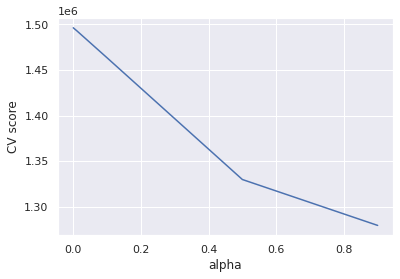

In [262]:
np.random.seed(0)

# Условный набор значений параметра alpha.
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 0.9]
searcher = GridSearchCV(LinReg(), [{"alpha": alphas}], scoring="neg_mean_squared_error", cv=5)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xlabel("alpha")
plt.ylabel("CV score")

Согласно графику, чем выше значение параметра $alpha$, тем лучше. Например, в тестовой выборке наилучшим оказалось значение $0.9$.

Best max_iter = 1500.0000


Text(0, 0.5, 'CV score')

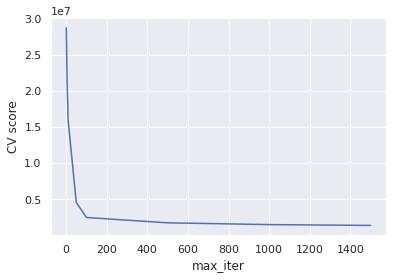

In [263]:
np.random.seed(0)

# Условный набор значений итераций.
max_iter = [1, 5, 10, 50, 100, 500, 1000, 1500]
searcher = GridSearchCV(LinReg(), [{"max_iter": max_iter}], scoring="neg_mean_squared_error", cv=5)
searcher.fit(X_train_scaled, y_train)

best_max = searcher.best_params_["max_iter"]
print("Best max_iter = %.4f" % best_max)

plt.plot(max_iter, -searcher.cv_results_["mean_test_score"])
plt.xlabel("max_iter")
plt.ylabel("CV score")

На графике видно, что адекватные значения начинаются при $max_iter > 100$, после чего лишь незначительные улучшения.   
Я предполагала, что рост числа итераций благоприятно сказывается на процессе оптимизации, так что ожидания совпали 🦾

#### 8. [1 points] Plot graphs (on the same picture) of the dependence of the loss function value on the iteration number for Full GD, SGD, Momentum and Adagrad. Draw conclusions about the rate of convergence of various modifications of gradient descent.

Don't forget about what *beautiful* graphics should look like!

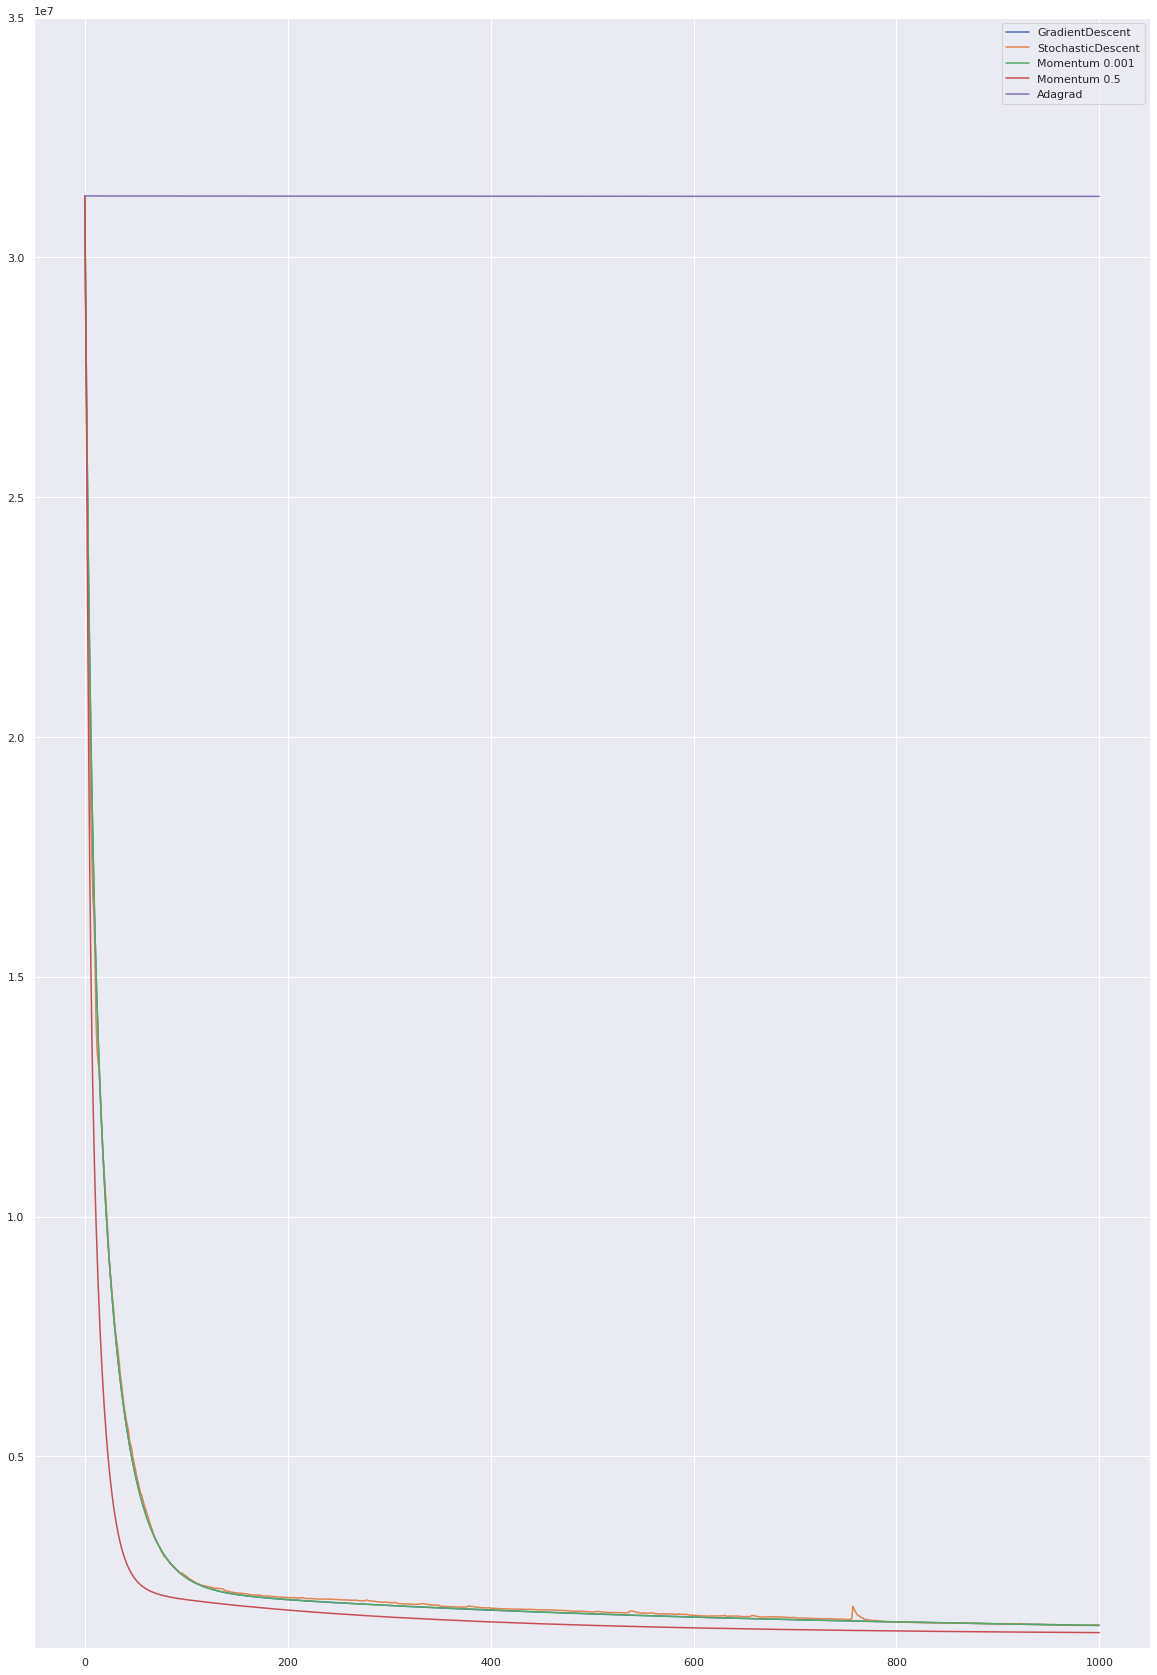

In [266]:
np.random.seed(0)

# Full GD.
fgd = LinReg(gd_type='GradientDescent')
fgd.fit(X_train_scaled, y_train)

# SGD.
sgd = LinReg(gd_type='StochasticDescent', delta = 0.001)
sgd.fit(X_train_scaled, y_train)

# Momentum (маленькая alpha по умолчанию).
momentum1 = LinReg(gd_type='Momentum')
momentum1.fit(X_train_scaled, y_train)

# Momentum с настроенной alpha.
momentum2 = LinReg(gd_type='Momentum', alpha = 0.5)
momentum2.fit(X_train_scaled, y_train)


# Adagrad.
adagrad = LinReg(gd_type='Adagrad')
adagrad.fit(X_train_scaled, y_train)

x = np.array(range(len(fgd.loss_history)))
plt.figure(figsize=(20, 30))

plt.plot(x, fgd.loss_history, label="GradientDescent")
plt.plot(x, sgd.loss_history, label="StochasticDescent")
plt.plot(x, momentum1.loss_history, label="Momentum 0.001")
plt.plot(x, momentum2.loss_history, label="Momentum 0.5")

plt.plot(x, adagrad.loss_history, label="Adagrad")
plt.ylim(1000000, 35000000)
plt.legend()
plt.show()

По графику видно, что с ростом количества итераций все методы пытаются сойтись к единому значению. При этом наиболее "плавной" сходиомстью обладает Full GD, с ним вровень идет метод $Momentum$ со значением параметра $alpha$ по умолчанию. При этом метод $Momentum$ со заданным значением параметра $alpha$ (более высоким), быстрее сходится к необходимому значению. Метод $StochasticDescent$ самый "непостоянный", наблюдаются сильные колебания при попытке сходиомсти.   
Ну а $Adagrad$ просто наевся и спит...